<a href="https://colab.research.google.com/github/AttiBae/BasicML/blob/main/Chapter4_MNIST_Classificationipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable as Variable
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import random

In [ ]:
MNIST_transform = transforms.Compose([transforms.Resize((28,28)),
                                   transforms.ToTensor()])

trainset = datasets.MNIST(root='./data/MNIST/', 
                           train=True,
                           download = True, 
                           transform=MNIST_transform)

testset = datasets.MNIST(root='./data/MNIST/', 
                           train=False, 
                           download = True, 
                           transform=MNIST_transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw




Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw




Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_loader = DataLoader(trainset, batch_size = 32, shuffle = True)
test_loader = DataLoader(testset, batch_size = 32, shuffle = True)

dataloaders = [train_loader, test_loader]

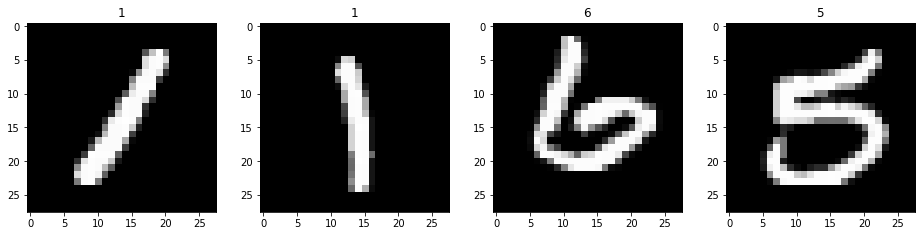

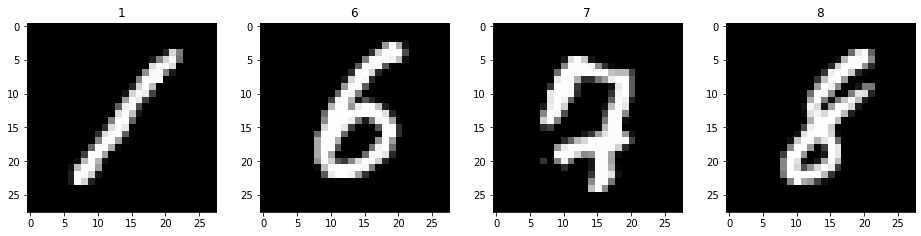

In [ ]:
image, label = next(iter(train_loader))

plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(4, 4, i+1)
    plt.imshow(image[i].squeeze(0), cmap='gray')
    plt.title(label[i].numpy())

image, label = next(iter(test_loader))

plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(4, 4, i+1)
    plt.imshow(image[i].squeeze(0), cmap='gray')
    plt.title(label[i].numpy())    

In [ ]:
class SimpleLayer(nn.Module):
    def __init__(self):
        super(SimpleLayer,self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        print(x.shape)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet,self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 32)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(1,16, kernel_size = 5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, 32)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


#model = SimpleLayer()
#model = LinearNet()
model = ConvNet()

if torch.cuda.is_available():
  device = torch.device('cuda')
  model = model.to(device)
  is_cuda = 1
else: is_cuda = 0

In [ ]:
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

num_epochs = 10

data_num = [len(trainset),len(testset)]

-----------------------------------
1 Epoch


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train	Loss : 0.0071962 Acc : 92.83
test	Loss : 0.0019184 Acc : 98.01
-----------------------------------
2 Epoch
train	Loss : 0.0019199 Acc : 98.095
test	Loss : 0.001376 Acc : 98.54
-----------------------------------
3 Epoch
train	Loss : 0.0013202 Acc : 98.693
test	Loss : 0.0010209 Acc : 99.03
-----------------------------------
4 Epoch
train	Loss : 0.0010454 Acc : 98.962
test	Loss : 0.0011065 Acc : 98.83
-----------------------------------
5 Epoch
train	Loss : 0.00081655 Acc : 99.135
test	Loss : 0.0010851 Acc : 98.93
-----------------------------------
6 Epoch
train	Loss : 0.0006491 Acc : 99.322
test	Loss : 0.0013062 Acc : 98.8
-----------------------------------
7 Epoch
train	Loss : 0.00057358 Acc : 99.425
test	Loss : 0.00084931 Acc : 99.3
-----------------------------------
8 Epoch
train	Loss : 0.00045362 Acc : 99.545
test	Loss : 0.001108 Acc : 99.0
-----------------------------------
9 Epoch
train	Loss : 0.00040608 Acc : 99.583
test	Loss : 0.00092554 Acc : 99.16
------------------

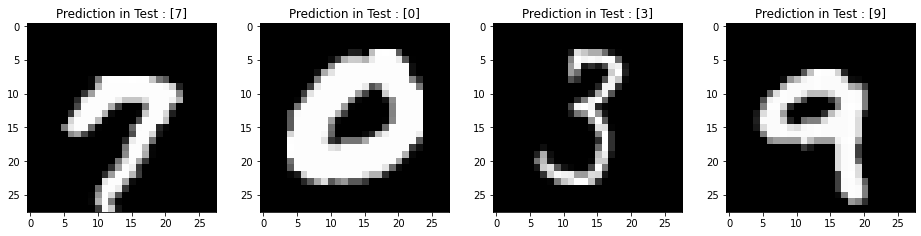

In [ ]:
start = time.time()
best_model = model.state_dict()
best_acc = 0.0

for epoch in range(num_epochs):
  print('-----------------------------------')
  print('{} Epoch'.format(epoch+1))

  for mode in ['train', 'test']:
    if mode == 'train':
      model.train(True)
      flag = 0
    else:
      model.train(False)
      flag = 1

    running_loss = 0.0  ## Loss & Acc Initialize
    running_corrects = 0

    for (data, target) in dataloaders[flag]:  ## Read Data from dataloaders
      if is_cuda:
        data, target = data.cuda(), target.cuda()
      data. target = Variable(data).to(device), Variable(target).to(device)  ## CUDA Setting

      optimizer.zero_grad()  ## Optimizer initialize every batch
      outputs = model(data)  ## Put images to network
      pred = outputs.data.max(dim=1, keepdim=True)[1]  ## prediction - MNIST data represented each 0 ~ 9
      loss = criterion(outputs, target)

      if mode == 'train':
        loss.backward()  ## get gradient
        optimizer.step()  ## optimizer task for network's train

      running_loss += loss.item()
      running_corrects += pred.eq(target.data.view_as(pred)).cpu().sum()

    epoch_loss = running_loss / data_num[flag]
    epoch_acc = running_corrects / data_num[flag] * 100  ## Accuracy (0~100%)
    print('{}\tLoss : {:.5} Acc : {:.5}'.format(mode, epoch_loss, epoch_acc))
    
    if mode == 'test' and epoch_acc > best_acc:  ## Store best-performed model data
      best_acc = epoch_acc
      best_model = model.state_dict()

 

elapsed_time = time.time() - start
print('Elapsed time : {}s'.format(elapsed_time))
plt.figure(figsize=(16, 16)) 
for i in range(4):
  plt.subplot(4, 4, i+1)
  plt.imshow(data[i].cpu().squeeze(0).numpy(), cmap='gray')
  plt.title('Prediction in Test : {}'.format(pred[i].cpu().numpy()))
plt.show()

torch.save(model.state_dict(), '/content/drive/MyDrive/BasicML/Chapter4/mnist_model.pt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from glob import glob
import os

path = '/content/drive/MyDrive/BasicML/Chapter4/My_MNIST/'
files = glob(os.path.join(path, '*/*.jpg'))

print(f'Total # of images {len(files)}')

Total # of images 64


In [ ]:
MNIST_transform = transforms.Compose([transforms.Resize((28,28)),
                                   transforms.Grayscale(1),
                                   transforms.ToTensor()])

validset = datasets.ImageFolder(path, MNIST_transform)
valid_loader = DataLoader(validset, batch_size = 32, shuffle = True)

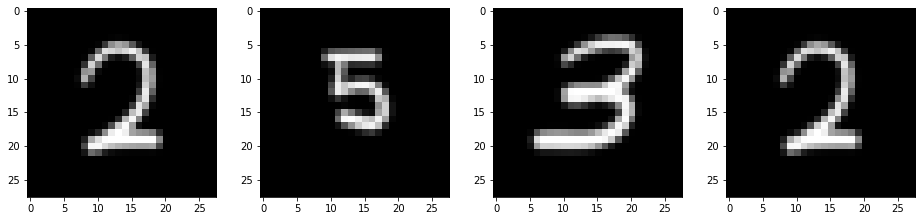

In [ ]:
image, label = next(iter(valid_loader))
plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(4, 4, i+1)
    plt.imshow(image[i,0,:,:], cmap='gray')

In [ ]:
model.load_state_dict(best_model)
model.eval()

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=32, bias=True)
)

In [ ]:
for (data, _) in valid_loader:  ## Read Data
      if is_cuda:
        data = data.cuda()
      data = Variable(data).to(device) ## CUDA Setting

      outputs = model(data)  ## Put images to network
      pred = outputs.data.max(dim=1, keepdim=True)[1]  ## prediction

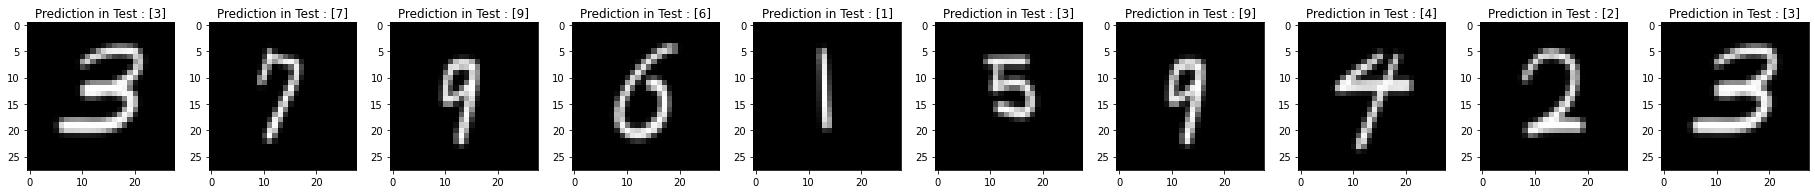

In [ ]:
plt.figure(figsize=(32, 32))  
for i in range(10):
  plt.subplot(10, 10, i+1)
  plt.imshow(data[i].cpu().numpy()[0], cmap='gray')
  plt.title('Prediction in Test : {}'.format(pred[i].cpu().numpy()))
plt.show()